Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 9.  Winter 2026.

The goal of optimization is to find the minimum or maximum of a function.  This is particularly useful in machine learning because we want to train our models to minimize their error.  In this class we'll be focused on gradient-based optimization methods.  If I can take the gradient (derivative) of a function, then its minimum will be in the opposite direction of the gradient- it will be downhill.  

We will first see how to automatically differentiate a function using <code>jax</code> and then we'll use these gradients to optimize functions.

# Automatic Differentiation

The <code>jax</code> library is useful for automatic differentiation.  Here we'll first define a function and then use <code>jax</code> synthax and functions to get its derivative without having to do any handwritten math ourselves.  Here we'll test with the function $y = (x+a)(x+b)(x+c)(x+d)$.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

Calculation time:  60.54300284385681  seconds


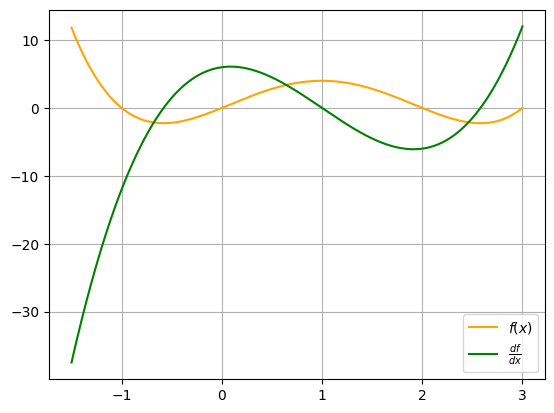

In [2]:
#define function
def f(x):
  a = -2.0
  b = 0.0
  c = 1.0
  d = -3.0

  y = (x+a)*(x+b)*(x+c)*(x+d)
  return y

#use jax to define the gradient of the function
df_dx = jax.grad(f)

#let's see how it works
x = np.linspace(-1.5, 3.0, 10000)
y = []
dydx = []

#let's also see how long this calculation takes
start_time = time.time()
for i in x:
  #calculate the function and its derivatives
  y.append(f(i))
  dydx.append(df_dx(i))

end_time = time.time()
print('Calculation time: ', end_time-start_time, ' seconds')

fig,ax = plt.subplots()
ax.plot(x, y, color='orange', label='$f(x)$')
ax.plot(x, dydx, color='green', label='$\\frac{df}{dx}$')
ax.legend()
ax.grid()

plt.show()


That was pretty slow.  The reason it was slow is that for every single calculation, <code>jax</code> is recomputing what the derivative function needs to be.  Using <code>jit</code> tells the program to only compile the functions once at the beginning and it will then reuse them, which makes everything much faster.  It stands for 'just-in-time' compilation.

Calculation time:  0.34668636322021484  seconds


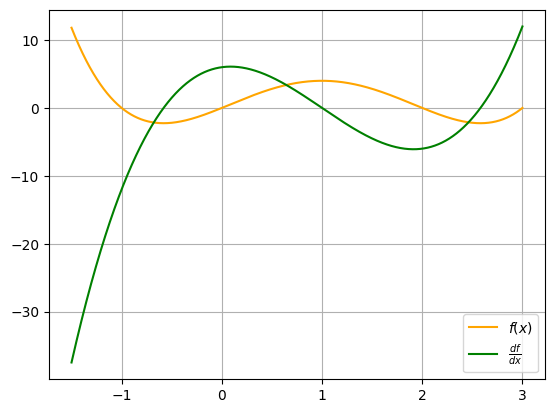

In [3]:
#define function
@jax.jit
def f(x):
  a = -2.0
  b = 0.0
  c = 1.0
  d = -3.0

  y = (x+a)*(x+b)*(x+c)*(x+d)
  return y

#use jax to define the gradient of the function
df_dx = jax.jit(jax.grad(f))

#let's see how it works
x = np.linspace(-1.5, 3.0, 10000)
y = []
dydx = []

#let's see how long this calculation takes
start_time = time.time()

for i in x:
  y.append(f(i))
  dydx.append(df_dx(i))

end_time = time.time()
print('Calculation time: ', end_time-start_time, ' seconds')

fig,ax = plt.subplots()
ax.plot(x, y, color='orange', label='$f(x)$')
ax.plot(x, dydx, color='green', label='$\\frac{df}{dx}$')
ax.legend()
ax.grid()

plt.show()

We can also vectorize the computation with <code>numpy</code> arrays, but they have to be special <code>jax</code> enabled <code>numpy</code> arrays.  This is how it works.

Calculation time:  0.2357161045074463  seconds


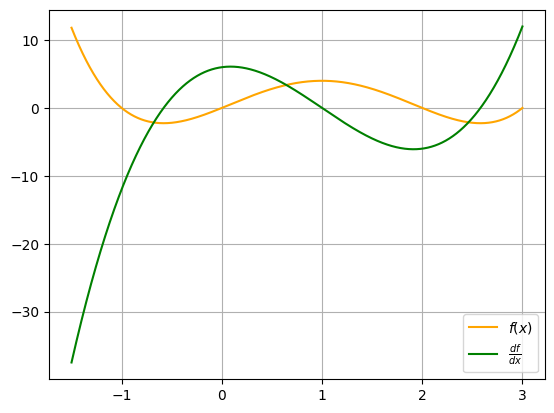

In [4]:
#define function
@jax.jit
def f(x):
  a = -2.0
  b = 0.0
  c = 1.0
  d = -3.0

  y = (x+a)*(x+b)*(x+c)*(x+d)
  return y

#use jax to define the gradient of the function
df_dx = jax.jit(jax.grad(f))

#this time we create an array with jnp- jax numpy
x = jnp.linspace(-1.5, 3.0, 10000)

#let's see how long this calculation takes
start_time = time.time()

#we also vectorize the gradient and function computation
dydx = jax.vmap(df_dx)(x)
y = jax.vmap(f)(x)

end_time = time.time()
print('Calculation time: ', end_time-start_time, ' seconds')

fig,ax = plt.subplots()
ax.plot(x, y, color='orange', label='$f(x)$')
ax.plot(x, dydx, color='green', label='$\\frac{df}{dx}$')
ax.legend()
ax.grid()

plt.show()


We can also use <code>jax</code> to get the derivative of functions with multiple inputs.  For inputs $x_1$, $x_2$,...,$x_n$, <code>jax</code> can return the gradient $\nabla f = [\partial f/\partial x_1, \partial f/\partial x_2,...,\partial f/\partial x_n, ]^{T}$.  Here we'll test with the function $y = (x_1+a)(x_2+b)(x_3+c)(x_1+d)$.

In [5]:
#define function
@jax.jit
def f(x1, x2, x3):
  a = -2.0
  b = 0.0
  c = 1.0
  d = -3.0

  y = (x1 + a)*(x2 + b)*(x3 + c)*(x1 + d)
  return y

#use jax to define the gradient of the function
df = jax.jit(jax.grad(f, argnums=(0, 1, 2))) #this means differentiate with respect to the first 3 arguments of the function

#this time we create an array with jnp- jax numpy
x1 = jnp.linspace(-1.5, 3.0, 10000)
x2 = jnp.linspace(-1.5, 3.0, 10000)
x3 = jnp.linspace(-1.5, 3.0, 10000)

#let's see how long this calculation takes
start_time = time.time()

#we also vectorize the gradient and function computation
gradient = jax.vmap(df)(x1, x2, x3)
y = jax.vmap(f)(x1, x2, x3)

end_time = time.time()
print('Calculation time: ', end_time-start_time, ' seconds')


Calculation time:  0.1529850959777832  seconds


# Gradient Descent

We've figured out how to get gradients, now we can do gradient descent.  With this we iteratively take steps in the direction of the negative gradient of a function to find its minimum.  Let's start by finding the minimum value of a parabola $y = (x-1)^2 + 2$.

Number of iterations:  62
Location of minimum:  0.99999607
Value of minimum:  2.0


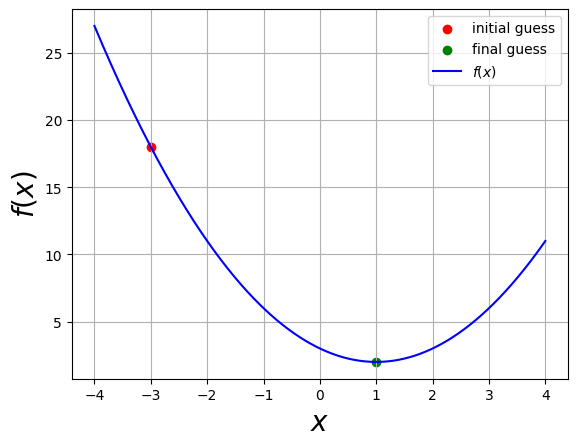

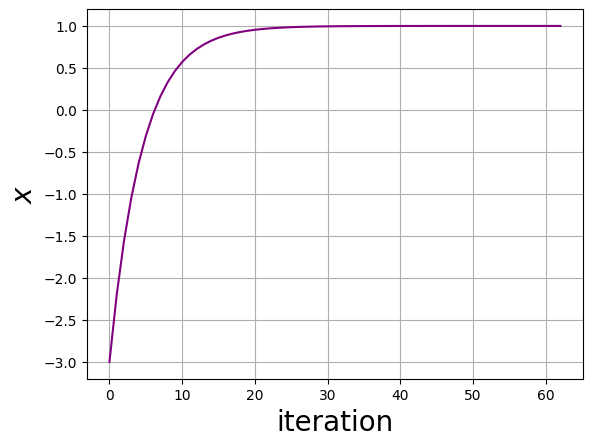

In [6]:
#function
@jax.jit
def f(x):
  return (x-1)**2 + 2.0

#derivative with jax
df = jax.jit(jax.grad(f))

#make a function for gradient descent
def gradient_descent(x, lr):
  #set up an array to record what our estimates for the minimum x-value is
  record = []
  record.append(x)

  #iteratively calculate the gradient and use it to update our guess for x
  converged = False
  eps = 1e-5
  iterations = 0
  max_iterations = 1000
  while not converged:
    #calculate the gradient
    grad = df(x)

    #update x
    x = x - lr*grad

    #record this value of x
    record.append(x)

    #update the number of iterations
    iterations += 1

    #check to see if we've converged
    if abs(grad) < eps or iterations > max_iterations:
      converged = True

  return x, record, iterations

#define the learning rate
lr = 0.1

#start with a guess for where the minimum is
x = -3.0

#do gradient descent
x, rec, iter = gradient_descent(x, lr)


#print the value of the location of the minimum and the value of the function at the minimum:
print('Number of iterations: ', iter)
print('Location of minimum: ', x)
print('Value of minimum: ', f(x))

#plot the initial guess, final guess, and function
fig, ax = plt.subplots()
ax.scatter(rec[0], f(rec[0]), color='r', marker='o', label='initial guess')
ax.scatter(rec[-1], f(rec[-1]), color='g', marker='o', label='final guess')
x_plot = jnp.linspace(-4.0, 4.0, 1000)
y_plot = jax.vmap(f)(x_plot)
ax.plot(x_plot, y_plot, color='blue', label='$f(x)$')
ax.set_xlabel('$x$',fontsize=20)
ax.set_ylabel('$f(x)$',fontsize=20)
ax.legend()
ax.grid()

#let's also see how the value of x changes through the minimization procedure
fig2, ax2 = plt.subplots()
ax2.plot(np.arange(0,iter+1), rec, color='purple')
ax2.set_xlabel('iteration',fontsize=20)
ax2.set_ylabel('$x$',fontsize=20)
ax2.grid()

plt.show()

Let's look at the effect of learning rate.  We'll see how quickly (or slowly) we approach the solution based on the learning rate.

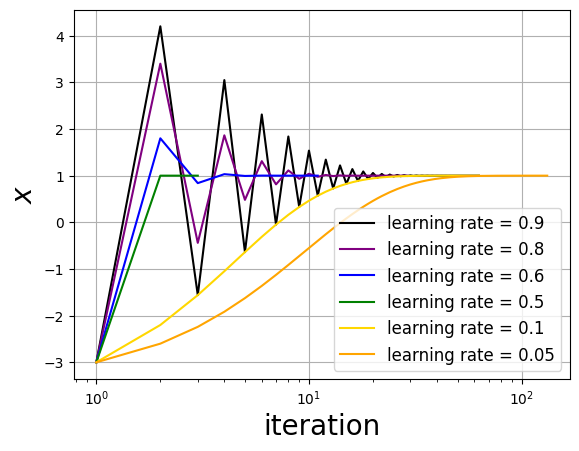

In [7]:
#look at some different learning rates
learning_rates = [0.9, 0.8, 0.6, 0.5, 0.1, 0.05]
colors = ['k','purple','b','g','gold','orange']

#set up a plot
fig, ax = plt.subplots()

for lr,c in zip(learning_rates,colors):
  #start with a guess for where the minimum is
  x = -3.0

  #do gradient descent
  x, rec, iter = gradient_descent(x, lr)

  ax.plot(np.arange(1,iter+2), rec, color=c, label='learning rate = '+str(lr))

ax.set_xscale('log')
ax.set_xlabel('iteration',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.legend(fontsize=12)
ax.grid()
plt.show()

There is usually an optimal learning rate.  If the rate is too low, it takes many iterations as the algorithm takes tiny steps towards the minimum.  If the rate is too high then the algorithm can overshoot the minimum and take many iterations to oscillate towards the minimum.  If the learning rate is very high, the algorithm can become unstable, never reaching the minimum.  Let's look at a 2-D example, too.  Here we'll try to find the minimum of $y = -3 e^{ - \frac{1}{2} x_1^2 + 2 x_2^2 }$.

Number of iterations:  571


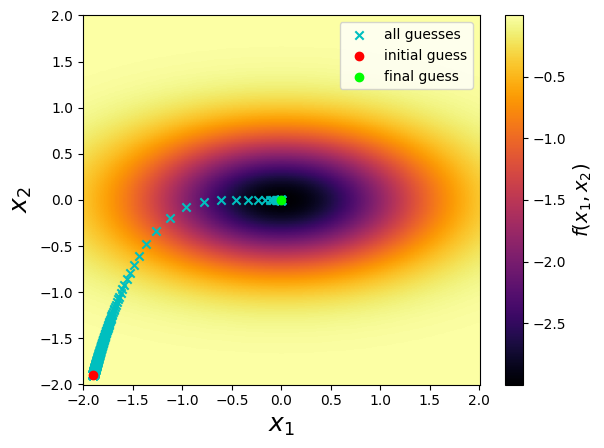

In [8]:
#function
@jax.jit
def f(x1, x2):
  return -3.0 * jnp.exp( -(0.5*x1**2 + 2.0*x2**2) )

#derivative with jax
df = jax.jit(jax.grad(f, argnums=(0, 1)))

#make a function for gradient descent
def gradient_descent(x1, x2, lr):
  #set up an array to record what our estimates for the minimum x-value is
  record = []
  record.append([x1, x2])

  #iteratively calculate the gradient and use it to update our guess for x
  converged = False
  eps = 1e-5
  iterations = 0
  max_iterations = 1000
  while not converged:
    #calculate the gradient
    grad = df(x1, x2)

    #update x1 and x2
    x1 = x1 - lr*grad[0]
    x2 = x2 - lr*grad[1]

    #record this value of x
    record.append([x1, x2])

    #update the number of iterations
    iterations += 1

    #check to see if we've converged
    if np.linalg.norm([x1, x2]) < eps or iterations > max_iterations:
      converged = True

  return x1, x2, record, iterations

#define the learning rate
lr = 0.1

#start with a guess for where the minimum is
x1 = -1.9
x2 = -1.9

#do gradient descent
x1, x2, rec, iter = gradient_descent(x1, x2, lr)

#print the number of iterations
print('Number of iterations: ', iter)

# Create a meshgrid for the (x, y) coordinates
x_plot = jnp.linspace(-2, 2, 500)
y_plot = jnp.linspace(-2, 2, 500)
x_grid, y_grid = jnp.meshgrid(x_plot, y_plot)

# Evaluate the function over the grid
Z = jax.vmap(f)(x_grid, y_grid)

# Plot the heatmap using imshow
fig,ax = plt.subplots()
c = ax.pcolormesh(x_grid, y_grid, Z, cmap='inferno', shading='auto')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('$f(x_{1}, x_{2})$',fontsize=14)
ax.scatter([row[0] for row in rec], [row[1] for row in rec], color='c', marker='x', label='all guesses')
ax.set_xlabel('$x_{1}$',fontsize=18)
ax.set_ylabel('$x_{2}$',fontsize=18)
ax.scatter(rec[0][0], rec[0][1], color='r', marker='o', label='initial guess')
ax.scatter(rec[-1][0], rec[-1][1], color='lime', marker='o', label='final guess')
ax.legend(loc='upper right')
plt.show()